In [1]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = np.array(
    [

        "1290-2023-01-31-13-22-58-3ef10981",
        "1002-2022-12-14-11-43-58-23e05b8c",
    ]
)


In [2]:
rec = video_loader(of_params)

In [219]:
ts, images_left, images_right = rec._get_frames(clip_names[0], convert_to_gray=True)
blink_df = rec._load_gt_labels(clip_names[0])


adding frame 25143
adding frame 25144
adding frame 25145
adding frame 25146
adding frame 25147
adding frame 25148
adding frame 25149
adding frame 25150
adding frame 25151
adding frame 25152
adding frame 25153
adding frame 25154
adding frame 25155
adding frame 25156
adding frame 25157
adding frame 25158
adding frame 25159
adding frame 25160
adding frame 25161
adding frame 25162
adding frame 25163
adding frame 25164
adding frame 25165
adding frame 25166
adding frame 25167
adding frame 25168
adding frame 25169
adding frame 25170
adding frame 25171
adding frame 25172
adding frame 25173
adding frame 25174
adding frame 25175
adding frame 25176
adding frame 25177
adding frame 25178
adding frame 25179
adding frame 25180
adding frame 25181
adding frame 25182
adding frame 25183
adding frame 25184
adding frame 25185
adding frame 25186
adding frame 25187
adding frame 25188
adding frame 25189
adding frame 25190
adding frame 25191
adding frame 25192
adding frame 25193
adding frame 25194
adding frame

In [157]:
ts.shape

(2604,)

105
163


In [47]:
of_params

OfParams(n_layers=1, layer_interval=0, average=False, img_shape=(64, 64), grid_size=10, step_size=5, window_size=11, stop_steps=3)

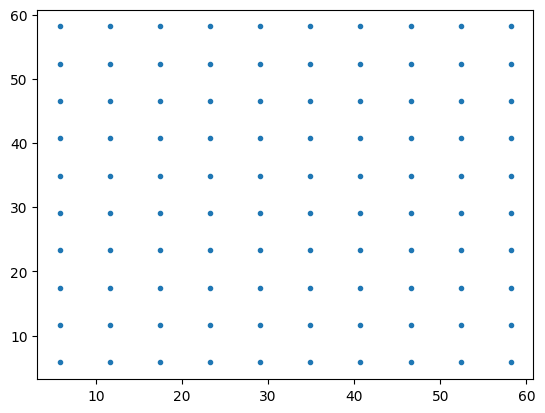

In [10]:
import matplotlib.pyplot as plt
plt.plot(grid[:, 0], grid[:, 1], ".")

In [ ]:
import scipy
a=scipy.interpolate.griddata(grid, feature_array[100, 0:100, 0], p_grid, method="nearest")

plt.imshow(p_grid, a)

In [33]:
x = np.linspace(0, 64, 65)

x = np.linspace(0, 64, 65, dtype=np.float32)[1:-1]
y = np.linspace(0, 64, 65, dtype=np.float32)[1:-1]
xx, yy = np.meshgrid(x, y)
p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [35]:
p_grid.shape

(3969, 2)

In [65]:
p

array([[ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       ...,
       [61., 63.],
       [62., 63.],
       [63., 63.]], dtype=float32)

In [235]:
from scipy.ndimage.interpolation import rotate

blink_ts = blink_df[blink_df["label"]=="onset"].iloc[6, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[5, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]
images_left_rot = np.zeros(images_left.shape)

for ifr in range(0, images_left.shape[0]):
    images_left_rot[ifr, :, :] = rotate(images_left[ifr, :, :], 30, reshape=False)

images_rot = images_left_rot[blink_on_idx-30:blink_off_idx+30, :, :]

feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
feature_array_rot, grid = rec._compute_optical_flow(of_params, images_left_rot, images_right)

feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]
feature_array_rot = feature_array_rot[blink_on_idx-30:blink_off_idx+30, :, :]

zz = np.zeros([63, 63, feature_array.shape[0]])
zz_rot = np.zeros([63, 63, feature_array.shape[0]])
frame_counter = 0

for iframe in range(0, feature_array.shape[0]):
    a=scipy.interpolate.griddata(grid, feature_array[iframe, 0:100, 1], p_grid, method="linear")
    b=scipy.interpolate.griddata(grid, feature_array_rot[iframe, 0:100, 1], p_grid, method="linear")
    count = 0
    for ix in range(0, 63):
        for iy in range(0, 63):
            zz[ix, iy, frame_counter] = a[count]
            zz_rot[ix, iy, frame_counter] = b[count]
            count += 1
    
    frame_counter += 1



/tmp/ipykernel_404570/4208859349.py:1: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


1183
1235


In [224]:
a.shape

(3969,)

In [236]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig, axs = plt.subplots(2,2)
im0 = axs[0, 0].imshow(video[0,:,:,:], cmap='gray')
axs[0, 0].axis("off")

im1 = axs[0, 1].imshow(zz[:,:,0], vmin=-10, vmax=10)
axs[0, 1].axis("off")

video1 = images_rot

im2 = axs[1, 0].imshow(video1[0,:,:,:], cmap='gray')
axs[1, 0].axis("off")

im3 = axs[1, 1].imshow(zz_rot[:,:,0], vmin=-10, vmax=10)
axs[1, 1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:,:])
    im1.set_data(zz[:,:,0])
    im2.set_data(video1[0,:,:,:])
    im3.set_data(zz_rot[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:,:])
    im1.set_data(zz[:,:,i])
    im2.set_data(video1[i,:,:,:])
    im3.set_data(zz_rot[:,:,i])
    return im0, im1, im2, im3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

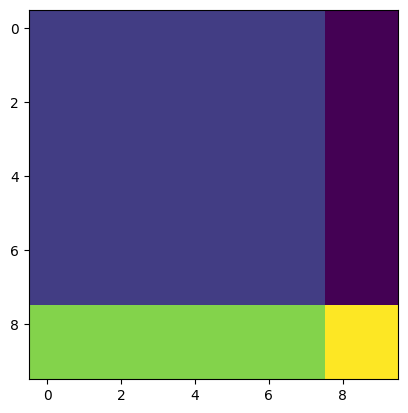

In [234]:
plt.imshow(zz[0:10, 0:10, 0])

In [237]:
zz.shape

(63, 63, 112)

In [227]:
10*10

100

In [238]:
timestamps = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16])

In [248]:
np.where(np.diff(timestamps)>1)[0][0]

9

In [249]:
timestamps[0:9]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])